# Credit Card Default Predictor
How can banks predict if their custumers will default on their next credit card payment or not? This is important because if banks were able to predict which of their customers will default on their next payment, then they would be able to successfully manage their funds/assets. A credit card default predictor can be developed using python, whereas 3 different models are used (logistic regression, classification trees, and the Naive Bayes Classifier) to accurately predict whether a customer will default their next payment based on a give set of data.

In [15]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from collections import OrderedDict

# Preparing the Data

In [16]:
# Extracting data from .csv file.
file = 'C:\\Users\\alhut\\OneDrive\\Desktop\\credit card default project\\creditcard_default.csv'
dataset = pd.read_csv(file, index_col='ID')

dataset.rename(columns=lambda x: x.lower(), inplace=True) 

In [17]:
# Preparing the data using dummy features (one-hot encoding). Base values are: other_education, female, not_married.
dataset['grad_school'] = (dataset['education'] == 1).astype('int')
dataset['universty'] = (dataset['education'] == 2).astype('int')
dataset['high_school'] = (dataset['education'] == 3).astype('int')
dataset.drop('education', axis=1, inplace=True) # Drops the education column because all the information is available in the features above.

dataset['male'] = (dataset['sex'] == 1).astype('int')
dataset.drop('sex', axis=1, inplace=True)

dataset['married'] = (dataset['marriage'] == 1).astype('int')
dataset.drop('marriage', axis=1, inplace=True)

# In the case of pay features, <= 0 means the payment was not delayed.
pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    dataset.loc[dataset[p]<=0, p] = 0

dataset.rename(columns={'default_payment_next_month':'default'}, inplace=True) # Renames last column for convenience.

In [18]:
# Scaling and fitting the x and y variables and creating the x and y test and train variables.
target_name = 'default'
X = dataset.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = dataset[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [19]:
# Creating a confusion matrix.
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['TOTAL'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [20]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], columns=['LogisticReg','ClassTree','NaiveBayes'])

# Metrics
- **Accuracy:** The proportion of the total number of predictions that are correct.
- **Precision:** The proportion of positive predictions that are actually correct.
- **Recall:** The proportion of positive observed values correctly predicted as such.

**In this application:**

- **Accuracy:** Overall how often the model predicts correctly defaulters and non-defaulters.
- **Precision:** When the model predicts default: how often is correct?
- **Recall:** The proportion of actual defalters that the model will correctly predict as such.

### Which metric should I use?
- **False Positive:** A person who will pay predicted as defaulter.
- **False Negative:** A person who will default predicted as payer.

**False negatives are worse in this situation ==> Look for a better recall.**

# Creating a Module for Predictions

In [21]:
def model(classifier, name):
    classifier.fit(X_train, y_train)

    y_pred_test = classifier.predict(X_test)
    metrics.loc['accuracy',name] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    metrics.loc['precision',name] = precision_score(y_pred=y_pred_test, y_true=y_test)
    metrics.loc['recall',name] = recall_score(y_pred=y_pred_test, y_true=y_test)

    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    return CMatrix(CM)

# A. Logistic Regression

In [22]:
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
model(logistic_regression, 'LogisticReg')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


PREDICTION,pay,default,Total
TRUE,,,
pay,3365,140,3505
default,671,324,995
TOTAL,4036,464,4500


# B. Classification Trees

In [23]:
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)
model(class_tree, 'ClassTree')

PREDICTION,pay,default,Total
TRUE,,,
pay,3185,320,3505
default,634,361,995
TOTAL,3819,681,4500


# C. Naive Bayes Classifier

In [24]:
NBC = GaussianNB()
model(NBC, 'NaiveBayes')

PREDICTION,pay,default,Total
TRUE,,,
pay,2912,593,3505
default,439,556,995
TOTAL,3351,1149,4500


# Comparing and Adjusting Models

In [25]:
# Comparing the models with percentages.
100*metrics

,LogisticReg,ClassTree,NaiveBayes
accuracy,81.9778,78.8,77.0667
precision,69.8276,53.0103,48.3899
recall,32.5628,36.2814,55.8794


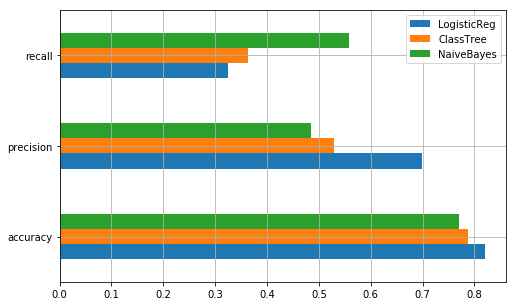

In [26]:
# Comparing the models with a bar graph.
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [27]:
# Adjusting the precision and recall values for the logistic regression model and the Naive Bayes Classifier model.
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, probas_pred=logistic_regression.predict_proba(X_test)[:,1])

In [28]:
# Creating a function for graphing.
def graphing(plot1, plot2, plot3, plot4, label1, label2, xlabel, ylabel, title, val1, val2, val3, color_val):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(plot1, plot2, label=label1)
    ax.plot(plot3, plot4, label=label2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.hlines(y=val1, xmin=val2, xmax=val3, color=color_val)
    ax.legend()
    return ax.grid();

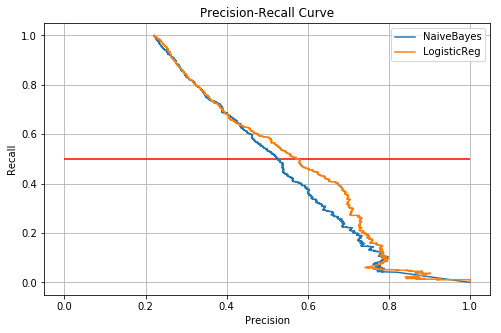

In [29]:
graphing(precision_nb, recall_nb, precision_lr, recall_lr, 'NaiveBayes', 'LogisticReg', 'Precision', 'Recall', 'Precision-Recall Curve', 0.5, 0, 1, 'r')

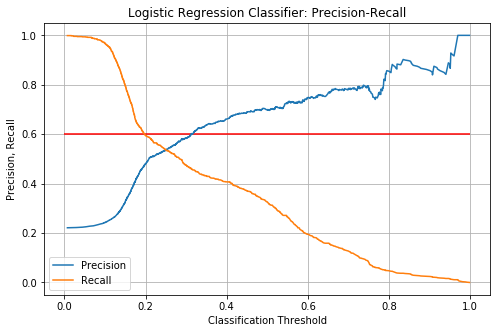

In [30]:
graphing(thresholds_lr, precision_lr[1:], thresholds_lr, recall_lr[1:], 'Precision', 'Recall', 'Classification Threshold', 'Precision, Recall', 'Logistic Regression Classifier: Precision-Recall', 0.6, 0, 1, 'r')

In [67]:
# Adjusting the threshold to 0.19.
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.19).astype('int')

In [68]:
# Confusion Matrix.
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print('Recall: ', str(100*recall_score(y_pred=y_pred_test, y_true=y_test)) + '%')
print('Precision: ', str(100*precision_score(y_pred=y_pred_test, y_true=y_test)) + '%')
print('Accuracy: ', str(100*accuracy_score(y_pred=y_pred_test, y_true=y_test)) + '%')
CMatrix(CM)

Recall:  62.010050251256274%
Precision:  45.83952451708767%
Accuracy:  75.4%


PREDICTION,pay,default,Total
TRUE,,,
pay,2776,729,3505
default,378,617,995
TOTAL,3154,1346,4500


# Making Individual Predictions

In [37]:
# Defining a function to make individual predictions.
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default.'
    else:
        return 'Will pay.'

In [38]:
# Making individual predictions using given data.
new_customer = OrderedDict([('limit_bal', 4000),('age', 50 ),('bill_amt1', 500),
                            ('bill_amt2', 35509 ),('bill_amt3', 689 ),('bill_amt4', 0 ),
                            ('bill_amt5', 0 ),('bill_amt6', 0 ), ('pay_amt1', 0 ),('pay_amt2', 35509 ),
                            ('pay_amt3', 0 ),('pay_amt4', 0 ),('pay_amt5', 0 ), ('pay_amt6', 0 ),
                            ('male', 1 ),('grad_school', 0 ),('university', 1 ), ('high_school', 0 ),
                            ('married', 1 ),('pay_0', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', 0),('pay_5', -1), ('pay_6', 0)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default.'

# Conclusion
In conclusion, my hypothesis was accurate, and the experiment was successful. Logistic regression appeared to be the most successful method, whereas it had the most recall, precision, accuracy. Now, if enough information is given, a bank can predict whether one of its customers might default on their next credit card payment or not.